# Audubon Park Land Encroachment

**[Interactive Map](https://s3.amazonaws.com/filestogeaux.garyscorner.net/pub/AudubonParkWalnutSt.html)**

During my walks in audubon park I have noticed a concerning trend.  It appears at least to me that homeowners are appropriating the public parks intended for all of us to use for the own benefit.  The main vehicle for this appropriation seems to be adding in landscaping which acts as a barrier.  Typically cast-iron or bambo.  This is my attempt to figure whats going on

#### Datasets
* Parcel Map:  https://data.nola.gov/dataset/Parcels/v9q5-fz7t

#### Info
* [Audubon targets intrusions into park ](http://saveaudubonpark.org/web/saparchive/p4088.htm)
* [Band v. Audubon Park Com'n](https://casetext.com/case/band-v-audubon-park-comn)



In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

from datetime import datetime

import shapely

import geoplot.crs as gcrs
import geoplot as gplt


import folium

import matplotlib.pyplot as plt
from matplotlib import patches

import pyproj

import gpxpy
import pickle

In [2]:
useCRS = 'EPSG:4326'
precisionCRS = 'EPSG:32615'

#this buffer was removed because the map is found to already be skewed in a way the decrease estimated encroachments.
#I will add this back later if I find a solution
#walkPathBuffer = 1.0  #using GPS + Galileo on garmin watch

In [3]:
makePrec = pyproj.Proj(pyproj.CRS(precisionCRS))

In [4]:
makePrec.crs

<Derived Projected CRS: EPSG:32615>
Name: WGS 84 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°W and 90°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Ontario. Ecuador -Galapagos. Guatemala. Mexico. United States (USA).
- bounds: (-96.0, 0.0, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
parcelsGpd = gpd.read_file('./datasets/Parcels.geojson')

In [6]:
parcelsGpd = parcelsGpd.to_crs(useCRS)

In [7]:
parcelsGpd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
#drop public property
parcelsGpd = parcelsGpd[ parcelsGpd['situs_street'] != 'Calhoun' ].copy()  #some kind of public property idk

In [9]:
parcelsGpd.head(2)

situs_dir       acres    geopin      perimeter situs_street objectid  \
0      None  2.33144428  41000085  1274.88858944        Teche        8   
1      None  2.53462307  41000073  1329.79083901         None        7   

  situs_number situs_type      shape_stlength        shape_starea  \
0         1550         St  1274.8885894439447   101557.7126865364   
1         None       None  1329.7908390045563  110408.18073966558   

                                            geometry  
0  MULTIPOLYGON (((-90.05297 29.94002, -90.05194 ...  
1  MULTIPOLYGON (((-90.04962 29.93506, -90.05003 ...

In [10]:
#hehe get it
audoBounds = [
    (-90.12766, 29.93341),
    (-90.12675, 29.93295),
    (-90.13137, 29.92641),
    (-90.13223, 29.92693),
    
    
]

audoBounds.append(audoBounds[0])

POLYGON ((-90.12766 29.93341, -90.12675 29.93295, -90.13137 29.92641, -90.13223 29.92693, -90.12766 29.93341))


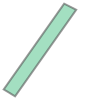

In [11]:
audoBoundsShape = shapely.geometry.Polygon([shapely.geometry.Point(*pt) for pt in audoBounds])
print(audoBoundsShape)

audoBoundsShape

In [12]:
audoBoundsShapeGS_wgs84 = gpd.GeoSeries(audoBoundsShape, crs='WGS84')
audoBoundsShapeGS = audoBoundsShapeGS_wgs84.to_crs(useCRS)

In [13]:
audoHousesMask = parcelsGpd['geometry'].intersects(audoBoundsShapeGS.iloc[0])

(np.count_nonzero(audoHousesMask), parcelsGpd.shape[0])


(33, 150935)

In [14]:
audubonCenter = shapely.geometry.box( *parcelsGpd[audoHousesMask].total_bounds ).centroid
list(audubonCenter.coords)[0]

(-90.128358945389, 29.925792067494)

<GeoAxesSubplot:>

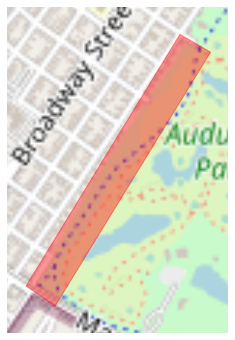

In [15]:
proj = gcrs.WebMercator()

ax = gplt.webmap(audoBoundsShapeGS, projection=proj, zoom=14)
gplt.polyplot(audoBoundsShapeGS, ax=ax, color='r', alpha=0.4 )



In [16]:
m = folium.Map(location=(audubonCenter.y,audubonCenter.x), zoom_start=16)

folium.Choropleth(geo_data=audoBoundsShapeGS, fill_color='red').add_to(m)

print("Target bounds (The area of investigation)")

m

Target bounds (The area of investigation)


In [17]:
audubonPark = gpd.GeoSeries( parcelsGpd[audoHousesMask].loc[parcelsGpd[audoHousesMask]['situs_number'] == '501']['geometry'])
privateProperties = parcelsGpd[audoHousesMask][parcelsGpd[audoHousesMask]['situs_number'] != '501']

In [18]:
privateProperties['geometry'] = privateProperties['geometry'].map(lambda g:  shapely.ops.unary_union( g.geoms ) )

<GeoAxesSubplot:>

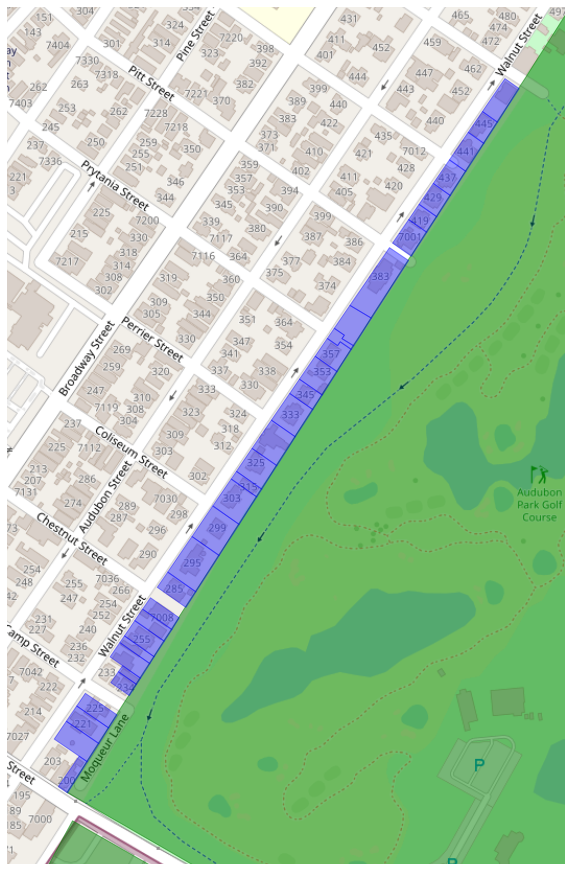

In [19]:
proj = gcrs.WebMercator()

fig, ax = plt.subplots(1, figsize=(10,20), subplot_kw={'projection':proj})
                       
                       

gplt.webmap(privateProperties,ax=ax)
gplt.polyplot(audubonPark, ax=ax, color='g', alpha=0.5 )
gplt.polyplot(privateProperties, ax=ax, color='b', alpha=0.4 )


In [20]:
def getEast(shape):
    coords = list(shape.exterior.coords)
    
    output = (-500,-500)
    
    for coord in coords:
        if coord[0] > output[0]:
            output = coord
            
    return shapely.geometry.Point( output )
    
privateProperties['EastCorner'] = gpd.GeoSeries( privateProperties['geometry'].map(getEast), crs='WGS84' )

In [21]:
def getSouth(shape):
    coords = list(shape.exterior.coords)
    
    output = (500,500)
    
    for coord in coords:
        if coord[1] < output[1]:
            output = coord
            
    return shapely.geometry.Point( output )
    
privateProperties['SouthCorner'] = gpd.GeoSeries( privateProperties['geometry'].map(getSouth), crs='WGS84' )

In [22]:
def getPropLine(row):
    return shapely.geometry.LineString([row['SouthCorner'], row['EastCorner']])

privateProperties['PropLine'] = gpd.GeoSeries( privateProperties.apply(getPropLine, axis=1), crs='WGS84')

C:\Users\gbezet\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:126: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [23]:

#WGS84 causes some caused the angles to be off.
def getPenaltyBox(row):

    pt1 =  np.array( makePrec(*row['SouthCorner'].xy)  ).reshape(2,)
    pt2 = np.array(  makePrec(*row['EastCorner'].xy)   ).reshape(2,)

    precisionLine = shapely.geometry.LineString( [pt1,pt2] )
    penalityLine = precisionLine.parallel_offset( 20 )
    
    penalityLineWGS84 = makePrec(*penalityLine.xy, inverse = True)
        
    pts = [ shapely.geometry.Point(penalityLineWGS84[0][idx],penalityLineWGS84[1][idx]) for idx in range(len(penalityLineWGS84[0]))]
    
    pts.append(row['SouthCorner'])
    pts.append(row['EastCorner'])
    
    return shapely.geometry.Polygon(pts)
    
    


privateProperties['PenalityBox'] = privateProperties.apply(getPenaltyBox, axis=1)


<GeoAxesSubplot:>

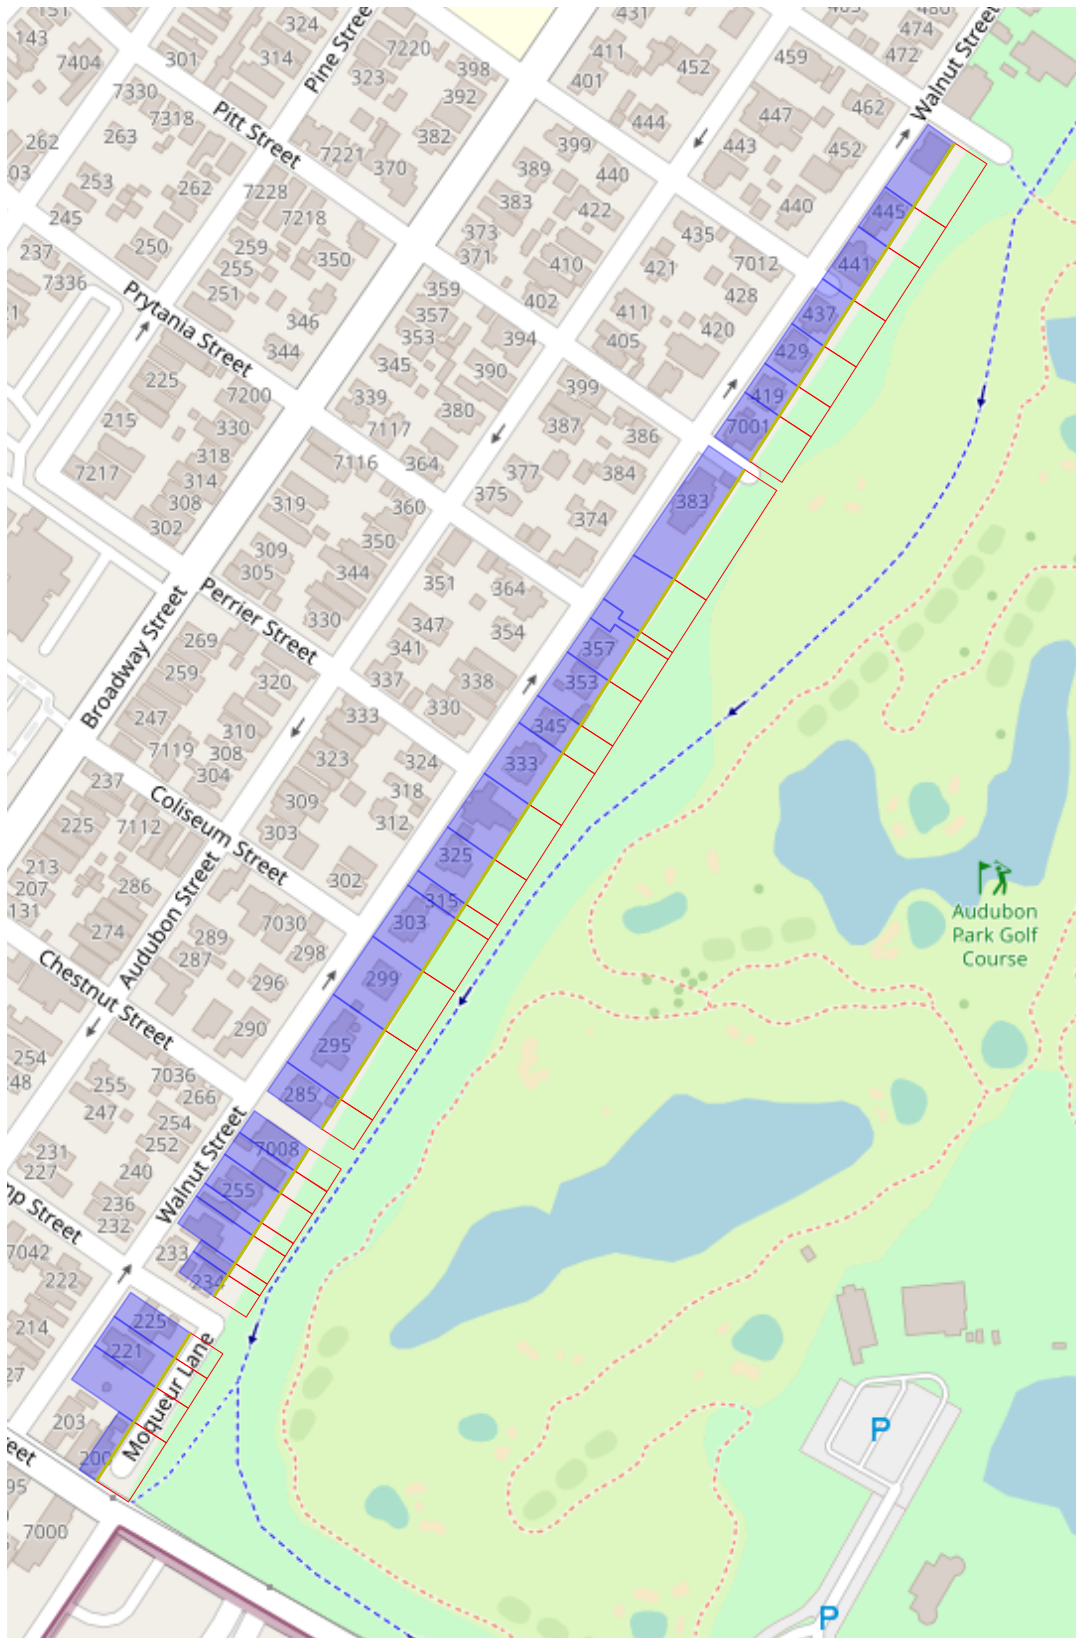

In [24]:
fig,ax=plt.subplots(figsize=(20,30),subplot_kw={'projection': gplt.WebMercator()})

#ax.set(projection=gplt.WebMercator())

gplt.webmap(privateProperties, ax=ax)

gplt.polyplot(privateProperties, color='blue', edgecolor='blue', ax=ax, alpha=0.3, linewidth=2, label='Property Parcel')


gplt.sankey(privateProperties['PropLine'], ax=ax, linewidth=3,color='y', label='Property Line with Audubon Park')

gplt.polyplot(privateProperties['PenalityBox'], ax=ax, edgecolor='r', label='Area of assume responsibility for property')




In [25]:
with open("datasets/activity_11849871333.gpx") as f:
    survey1 = gpxpy.parse(f)

In [26]:
survery1Pts = [pt for pt in \
 [shapely.geometry.Point((pt.longitude, pt.latitude)) for pt in survey1.tracks[0].segments[0].points]\
 if pt.within(audoBoundsShape)]

In [27]:
#cut out the excess data
survery1Pts.append(audoBounds[1])
survery1Pts.append(audoBounds[2])

In [28]:
survey1Shape =  shapely.geometry.Polygon(survery1Pts)
survey1Gpd = gpd.GeoSeries(survey1Shape, crs=useCRS)

<AxesSubplot:>

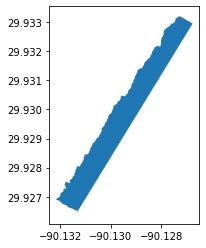

In [29]:
survey1Gpd.plot()

In [30]:
survey1PrecGpd = survey1Gpd.to_crs(precisionCRS).buffer(0)
audubonParkPrec = audubonPark.to_crs(precisionCRS)

#clip to audubon park
survey1PrecGpd = survey1PrecGpd.intersection(audubonParkPrec.iloc[0], align=False)

In [31]:
survey1Gpd = survey1PrecGpd.to_crs(useCRS)

<GeoAxesSubplot:>

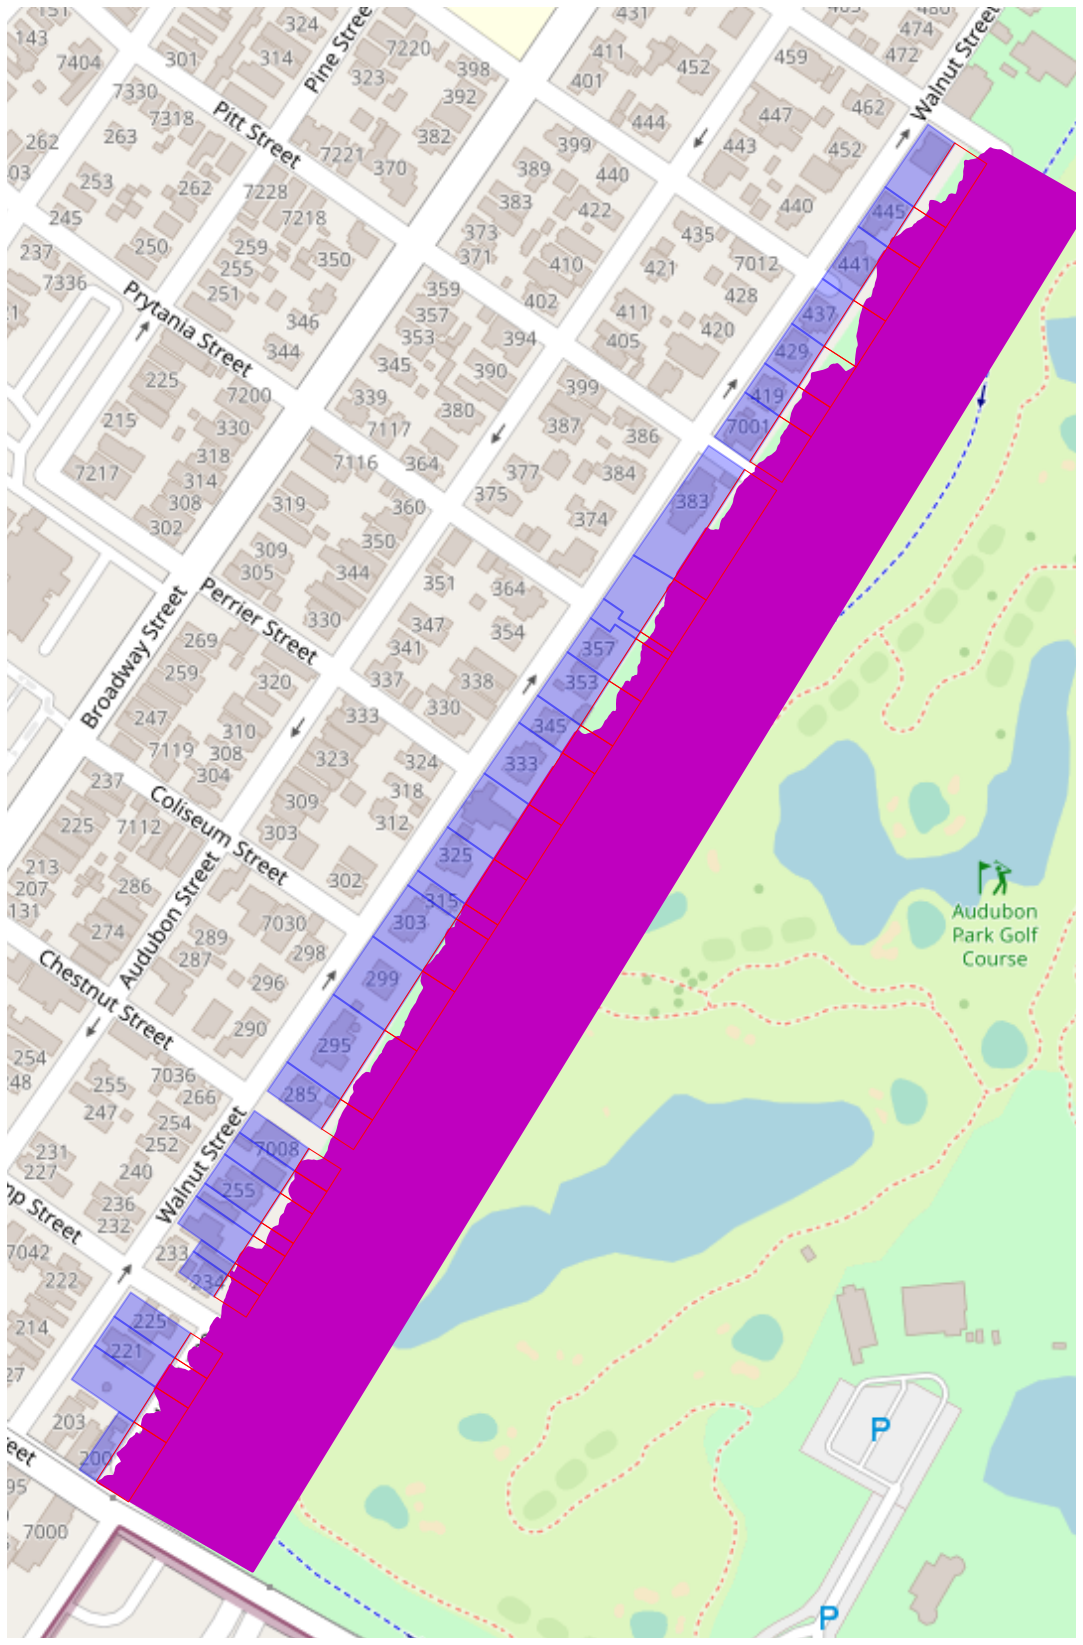

In [32]:
fig,ax=plt.subplots(figsize=(20,30),subplot_kw={'projection': gplt.WebMercator()})

#ax.set(projection=gplt.WebMercator())

gplt.webmap(privateProperties, ax=ax)

gplt.polyplot(privateProperties, color='blue', edgecolor='blue', ax=ax, alpha=0.3, linewidth=2, label='Property Parcel')

gplt.polyplot(survey1Gpd, ax=ax, linewidth=3,color='m', label='Survey 1')

gplt.polyplot(privateProperties['PenalityBox'], ax=ax, edgecolor='r', label='Area of assume responsibility for property')

In [33]:
def getPenaltiesAreaUTM(row):
        
    precPenaltyBox = shapely.geometry.Polygon(gpd.points_from_xy( *makePrec(*row['PenalityBox'].exterior.xy) ))
    
    penaltyShape = precPenaltyBox.difference(survey1PrecGpd.iloc[0])
        
    return penaltyShape

penaltyShapeUTM = privateProperties.apply(getPenaltiesAreaUTM, axis=1)

C:\Users\gbezet\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1565: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [34]:
penaltyShapeUTM.set_crs(precisionCRS, inplace=True)
penaltyShapeWGS84 = penaltyShapeUTM.to_crs(useCRS)

In [35]:
privateProperties['PenaltyArea'] = penaltyShapeUTM.area * 10.7639  #convert to ft^2

In [36]:
privateProperties['PenaltyRentPrice'] = privateProperties['PenaltyArea'] * 3.60

In [37]:
privateProperties['block'] = (privateProperties['situs_number'].astype(int) / 100).astype(int)
privateProperties['block'].value_counts()

block
2     13
3     11
4      7
70     1
Name: count, dtype: int64

In [38]:
privateProperties.loc[privateProperties['block'] == 70,'block'] = 2

In [39]:
totalPenaltyArea = privateProperties['PenaltyArea'].sum()
avgPenalityArea = privateProperties['PenaltyArea'].mean()
medianPenalityArea = privateProperties['PenaltyArea'].median()
privateProperties['PenaltyPercent'] = ( privateProperties['PenaltyArea'] / totalPenaltyArea ) * 100.0

print(f"""* Total encroached area = {totalPenaltyArea:.0f} sqft
* Mean Encroached Area = {avgPenalityArea:.0f} sqft
* Median Ecnroache Area = {medianPenalityArea:.0f} sqft""")

* Total encroached area = 41803 sqft
* Mean Encroached Area = 1306 sqft
* Median Ecnroache Area = 1099 sqft


In [40]:
blockPenaltySums = privateProperties.groupby('block')['PenaltyArea'].sum()
blockPenaltyPercs = blockPenaltySums / totalPenaltyArea * 100.0

for (idx, val), (idx2,val2) in zip(blockPenaltySums.items(),blockPenaltyPercs.items()):
    print(f"* {idx}00 Block Encroached Area {val:.0f} sqft ( {val2:0.1f}%) ")

* 200 Block Encroached Area 15323 sqft ( 36.7%) 
* 300 Block Encroached Area 9566 sqft ( 22.9%) 
* 400 Block Encroached Area 16915 sqft ( 40.5%) 


In [41]:


def getBlockPerc(row):
    return row['PenaltyArea'] / blockPenaltySums.loc[row['block']] * 100.0

privateProperties['PenaltyPercByBlock'] = privateProperties.apply(getBlockPerc, axis=1)

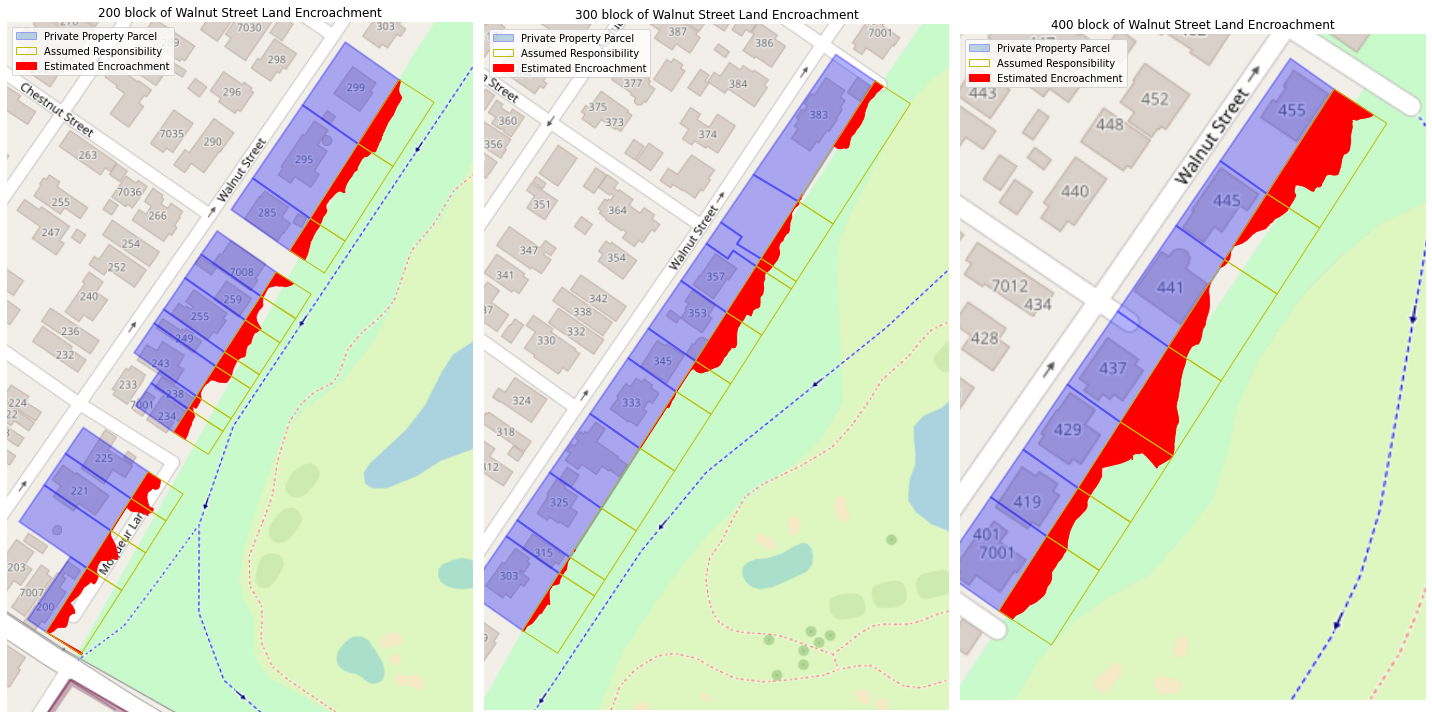

In [42]:
fig,axs=plt.subplots(figsize=(20,10), nrows=1,ncols=3,subplot_kw={'projection': gplt.WebMercator()})



axs = axs.reshape((3,))

legend = [
    patches.Patch(label='Private Property Parcel', alpha=0.3, edgecolor='blue'),
    patches.Patch(label='Assumed Responsibility', edgecolor='y',fill=False),
    patches.Patch(label='Estimated Encroachment', color='r')
    
]

for ax, block, label in zip(axs, range(2,5), legend):
    
    ax.set_title(f"{block}00 block of Walnut Street Land Encroachment")
    
    mask = privateProperties['block'] == block
    extent = privateProperties[mask].total_bounds
    
    gplt.webmap(privateProperties[mask], ax=ax, extent=extent, zoom=18)
    gplt.polyplot(privateProperties[mask], color='blue', edgecolor='blue', ax=ax, alpha=0.3, linewidth=2, label='Property Parcel')
    gplt.polyplot(penaltyShapeWGS84[mask], ax=ax, color='r', label='Estimated Encroachment')
    gplt.polyplot(privateProperties[mask]['PenalityBox'], ax=ax, edgecolor='y', label='Area of assume responsibility for property (~65 ft from parcel)')
    
    ax.legend(handles=legend, loc='upper left')

plt.tight_layout()
fig.savefig('AudubonParkWalnutSt.jpg')


In [43]:
#load photos data
with open('img_walnutstMetaData.pickle', 'rb') as f:
    photosDf = pickle.load(f)
   
photosDf['coords'] = photosDf['geometry'].map(lambda pt: f"Lat: {pt.y:.5f}N Lon: {pt.x * -1:.5f}W")

photosDf.head()

url  \
0  https://s3.amazonaws.com/filestogeaux.garyscor...   
1  https://s3.amazonaws.com/filestogeaux.garyscor...   
2  https://s3.amazonaws.com/filestogeaux.garyscor...   
3  https://s3.amazonaws.com/filestogeaux.garyscor...   
4  https://s3.amazonaws.com/filestogeaux.garyscor...   

                                          file                date  \
0  img_walnutst/IMG_20230920_115453460_HDR.jpg 2023-09-20 11:54:57   
1  img_walnutst/IMG_20230920_115540327_HDR.jpg 2023-09-20 11:55:43   
2  img_walnutst/IMG_20230920_115625903_HDR.jpg 2023-09-20 11:56:28   
3  img_walnutst/IMG_20230920_115804977_HDR.jpg 2023-09-20 11:58:07   
4  img_walnutst/IMG_20230920_115835241_HDR.jpg 2023-09-20 11:58:37   

            date_fromname                    geometry  \
0 2023-09-20 11:54:53.460  POINT (-90.13195 29.92710)   
1 2023-09-20 11:55:40.327  POINT (-90.13193 29.92719)   
2 2023-09-20 11:56:25.903  POINT (-90.13158 29.92749)   
3 2023-09-20 11:58:04.977  POINT (-90.13124 29.92806)   
4 2023-09-20 11:58:35.241  POINT (-90.13113 29.92820)   

                          coords  
0  Lat: 29.92710N Lon: 90.13195W  
1  Lat: 29.92719N Lon: 90.13193W  
2  Lat: 29.92749N Lon: 90.13158W  
3  Lat: 29.92806N Lon: 90.13124W  
4  Lat: 29.92820N Lon: 90.13113W

In [44]:
photosDf.iloc[0]['url']

'https://s3.amazonaws.com/filestogeaux.garyscorner.net/pub/img_walnutst/IMG_20230920_115453460_HDR.jpg'

In [45]:
defaultTiles = folium.TileLayer('OpenStreetMap')

m = folium.Map(location=(audubonCenter.y,audubonCenter.x), zoom_start=16, tiles=defaultTiles)

folium.TileLayer('stamenterrain', attr="<a href=\"https://maps.stamen.com/\">Stamen</a>").add_to(m)
folium.TileLayer('stamentoner', attr="<a href=\"https://maps.stamen.com/\">Stamen</a>").add_to(m)
folium.TileLayer('stamenwatercolor', attr="<a href=\"https://maps.stamen.com/\">Stamen</a>").add_to(m)

propChor = folium.Choropleth(geo_data=privateProperties['geometry'],\
                             fill_color='blue',\
                             name='Private Properties',\
                             highlight=True\
                            ).add_to(m)

folium.Choropleth(geo_data=penaltyShapeWGS84, \
                  fill_color='red', \
                  name='Encroached Area', \
                  highlight=True                  
                 ).add_to(m)

detailLayer = folium.map.FeatureGroup('Property Details')
for idx, row in privateProperties.iterrows():
    
    if row['PenaltyArea'] > 260:

        center = row['geometry'].centroid
        popup = f"""<nobr>Est. Area:   {row['PenaltyArea']:.0f} sqft</nobr><br />
                    <nobr>Area/Total:  {row['PenaltyPercent']:.1f}%</nobr><br />
                    <nobr>Area/Block Total:  {row['PenaltyPercByBlock']:.1f}%</nobr><br />"""
                    
        folium.Marker(location=[center.y,center.x], popup=popup, tooltip=popup, \
                      icon=folium.Icon(color="red", icon="glyphicon-zoom-in"), \
                      ).add_to(detailLayer)

photoLayer = folium.map.FeatureGroup(name='Photos')
for idx, row in photosDf.iterrows():
    
        popup = f"""{datetime.strftime(row['date'], '%B %d, %Y')}  ({row['coords']})<br />
                    <img src="{row['url']}" style="max-width:600px;max-height:600px" />
        """

        folium.CircleMarker(location=[row['geometry'].y,row['geometry'].x], popup=popup,  \
                            radius=5, color='darkblue', fillcolor='darkblue', fill=True,
                            fill_opacity=0.6,
                            tooltip='Click for photo'
                      #icon=folium.Icon(color="lightgray", icon="glyphicon-camera"), \
                      ).add_to(photoLayer)
m.add_child(detailLayer)    
m.add_child(photoLayer)
        
folium.LayerControl().add_to(m)




In [46]:
# add readme

readMe = """<a href="https://github.com/GarysCorner/NewOrleansLandEncroachment" target="_blank">Project Home (GitHub)</a><br />
            <i>Don\'t forget to check layers</i><br /> <br />\
            <ul>
                <li>
                    <a target="_blank" href="https://github.com/GarysCorner/NewOrleansLandEncroachment/blob/master/README.md#interactive-map-usage">Usage</a>
                </li>
                <li>
                    <a target="_blank" href="https://github.com/GarysCorner/NewOrleansLandEncroachment/blob/master/README.md#background">Background</a>
                </li>
                </li>
                <li>
                    <a target="_blank" href="https://github.com/GarysCorner/NewOrleansLandEncroachment/blob/master/README.md#datasets">Datasets</a>
                </li>
                <li>
                    <a target="_blank" href="https://github.com/GarysCorner/NewOrleansLandEncroachment/blob/master/README.md#disclaimer">Disclaimers</a>
                </li>
            </ul>

            """

    
reedMeMarker = folium.Marker(location=(audubonCenter.y,audubonCenter.x), \
            icon=folium.Icon(con="glyphicon-list-alt"),
             popup=folium.Popup(readMe,show=True,)).add_to(m)
 


In [47]:
#save it
m.save('AudubonParkWalnutSt.html')

In [48]:
#https://s3.amazonaws.com/filestogeaux.garyscorner.net/pub/AudubonParkWalnutSt.html
!aws s3 cp ./AudubonParkWalnutSt.html s3://filestogeaux.garyscorner.net/pub/ --acl public-read

Completed 142.7 KiB/142.7 KiB (179.7 KiB/s) with 1 file(s) remaining
upload: .\AudubonParkWalnutSt.html to s3://filestogeaux.garyscorner.net/pub/AudubonParkWalnutSt.html


### See map at https://s3.amazonaws.com/filestogeaux.garyscorner.net/pub/AudubonParkWalnutSt.html